<a href="https://colab.research.google.com/github/bo-bits/nn-zero-to-hero/blob/master/exercises/makemore_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
  In Andrej's notebook he reaches validation loss of 2.18 with 11897 free parameters
  Let's try and beat that...

  (1) Let's start by simply adding more features to the characters (10->20). Which gives us 18167 parameters (almost double).


*   Training loss: 2.0693
*   Validation loss: 2.1462
*   Parameters: 18167


  (2) If we also increase the hidden layer to 400 elements, up to 35767 free parameters, reduce training loss, but validation loss goes up. We have officially overfit our model. (yay)



*   Training loss: 2.0353
*   Validation loss: 2.1704
*   Parameters: 35767


(3) Let's try and increase the context to 4 characters


*   Training loss: 2.1382
*   Validation loss: 2.2274
*   Parameters: 43767

 Due to the high number of 4-character combinations that appear in the evaluation texts but nowhere in the training text. Hence, their predicted probability is zero.


Increasing the context increases the loss. Apparently this might be due to the loss being computed differently.

(4) Bring context down to 2 again (same architecture as (2)). Now add weight decay = 0.01

*   Training loss: 2.1495
*   Validation loss: 2.1718
*   Parameters: 35767

(5) Change weight decay to 0.001

*   Training loss: 2.1554
*   Validation loss: 2.1682
*   Parameters: 35767


E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

When we have a perfectly uniform distribution, all outputs are equally likely. Using cross_entropy this leads to a loss of log(m) where m is the number of classes. For our problem it would be ~3.3

We can achieve this loss by minimizing the initialization weights and setting biases of output layer to zero.


E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?




In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
words = open('names.txt', 'r').read().splitlines()

--2024-11-11 11:06:00--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-11-11 11:06:00 (6.20 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) * 0.001
W1 = torch.randn((30, 200), generator=g) * 0.001
b1 = torch.randn(200, generator=g) * 0.001
W2 = torch.randn((200, 27), generator=g) * 0.001
b2 = torch.zeros(27)
parameters = [C, W1, b1, W2, b2]

In [15]:
W2.shape

torch.Size([200, 27])

In [16]:
W2.sum(dim=1).shape

torch.Size([200])

In [17]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [18]:
for p in parameters:
  p.requires_grad = True

In [19]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [20]:
lri = []
lossi = []
stepi = []

In [21]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  # l2_penalty = 0.001 * (torch.square(W2).sum() + torch.square(W1).sum())
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  if i < 100000:
    lr = 0.1
  elif i < 150000:
    lr=  0.01
  else:
    lr = 0.001

  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print("-"*20, "Training Model   ", " ", "-"*20)
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print("Training loss: ", loss.item())
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print("Evaluation loss: ", loss.item())
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
print("Test loss: ", loss.item())

#   #print(loss.item())

-------------------- Training Model      --------------------
Training loss:  2.143941879272461
Evaluation loss:  2.1642792224884033
Test loss:  2.1641101837158203


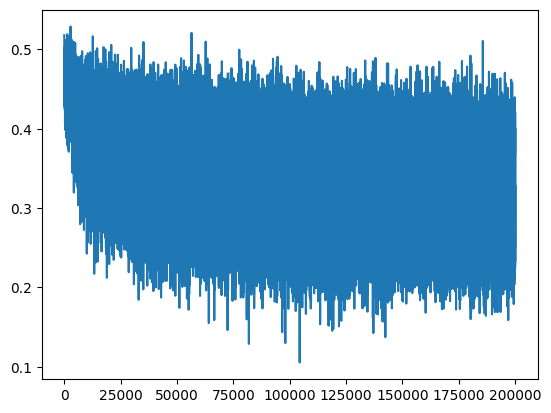

In [23]:
plt.plot(stepi, lossi)

In [29]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1439, grad_fn=<NllLossBackward0>)

In [27]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1643, grad_fn=<NllLossBackward0>)

In [26]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1641, grad_fn=<NllLossBackward0>)

In [30]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
kayah.
see.
med.
rylle.
emmacgendrael.
adered.
elin.
shi.
jen.
eden.
estanar.
katziviona.
cayshubergiaghiel.
kindreelle.
jetton.
kubrey.
dariyah.
faeh.
yuma.


In [55]:
#  EXERCISE 03 - Combine MLP with Interpolated Trigram Probabilitites
#  In Bengio et al. paper they mention improved performance by mixing output with probabilities of interpolated trigram model. So let's try it.
#  An interpolated trigram takes the combined counts of a unigram, bigram, and trigram model

# Create dataset of trigrams

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
words = open('names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)



--2024-11-11 11:50:44--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2024-11-11 11:50:44 (6.13 MB/s) - ‘names.txt.2’ saved [228145/228145]

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [56]:
# Create n-gram counts

unigram_counts = torch.zeros(27) + 10e-3
bigram_counts = torch.zeros((27,27)) + 10e-3
trigram_counts = torch.zeros((27, 27, 27)) + 10e-3

for w in words:
  w += "."
  for i, ch in enumerate(w):
    unigram_counts[stoi[w[i]]] += 1
    if i < 1:
      continue
    bigram_counts[stoi[w[i-1]], stoi[w[i]]] += 1
    if i < 2:
      continue
    trigram_counts[stoi[w[i-2]], stoi[w[i-1]], stoi[w[i]]] +=1

# Normalize Counts
unigram_probs = unigram_counts / unigram_counts.sum()
bigram_probs = bigram_counts / bigram_counts.sum(dim=1, keepdim=True)
trigram_probs = trigram_counts / trigram_counts.sum(dim=2, keepdim=True)



In [57]:
# Set interpolation weights
lambda_3 = 0.7  # Weight for trigram probability
lambda_2 = 0.2  # Weight for bigram probability
lambda_1 = 0.1  # Weight for unigram probability

In [58]:
# Interpolated probabilities

inter_probs = lambda_3 * trigram_probs + lambda_2 * bigram_probs + lambda_1 * unigram_probs


In [59]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [60]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) * 0.001
W1 = torch.randn((30, 200), generator=g) * 0.001
b1 = torch.randn(200, generator=g) * 0.001
W2 = torch.randn((200, 27), generator=g) * 0.001
b2 = torch.zeros(27)
parameters = [C, W1, b1, W2, b2]

In [61]:
for p in parameters:
  p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

alpha = 0.5 # Weight applied to interpolated loss

In [84]:

# minibatch construct
ix = torch.randint(0, Xtr.shape[0], (32,))

# forward pass
emb = C[Xtr[ix]] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)

# Get prob dist from interpolated model
inter_batch_probs = inter_probs[Xtr[ix][:, 1], Xtr[ix][:, 2], :]

# Convert mlp logits to probs via softmax
mlp_probs = F.softmax(logits, dim=1)

# Combine probabilities
combined_probs = mlp_probs * alpha + inter_batch_probs * (1-alpha)
loss = F.nll_loss(torch.log(combined_probs), Ytr[ix])
print(loss.item())

3.14431095123291


In [87]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)

  # Get prob dist from interpolated model
  inter_batch_probs = inter_probs[Xtr[ix][:, 1], Xtr[ix][:, 2], :]

  # Convert mlp logits to probs via softmax
  mlp_probs = F.softmax(logits, dim=1)

  # Combine probabilities
  combined_probs = mlp_probs * alpha + inter_batch_probs * (1-alpha)
  loss = F.nll_loss(torch.log(combined_probs), Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  if i < 100000:
    lr = 0.1
  elif i < 150000:
    lr=  0.01
  else:
    lr = 0.001

  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

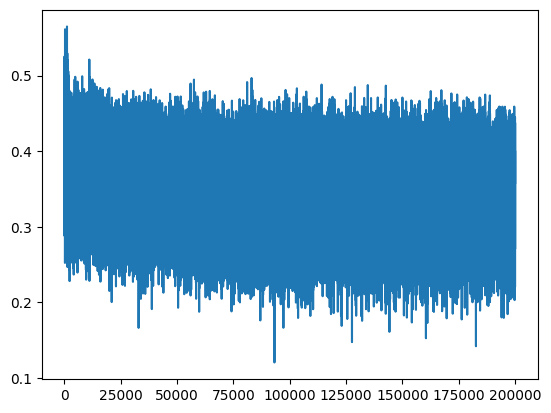

In [88]:
plt.plot(stepi, lossi)

In [93]:
# training loss
emb = C[Xtr] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
inter_batch_probs = inter_probs[Xtr[:, 1], Xtr[:, 2], :]
mlp_probs = F.softmax(logits, dim=1)
combined_probs = mlp_probs * alpha + inter_batch_probs * (1-alpha)
loss = F.nll_loss(torch.log(combined_probs), Ytr)
loss

tensor(2.1985, grad_fn=<NllLossBackward0>)

In [94]:
# dev loss
emb = C[Xdev] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
inter_batch_probs = inter_probs[Xdev[:, 1], Xdev[:, 2], :]
mlp_probs = F.softmax(logits, dim=1)
combined_probs = mlp_probs * alpha + inter_batch_probs * (1-alpha)
loss = F.nll_loss(torch.log(combined_probs), Ydev)
loss

tensor(2.2091, grad_fn=<NllLossBackward0>)

In [95]:
# test loss
emb = C[Xte] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
inter_batch_probs = inter_probs[Xte[:, 1], Xte[:, 2], :]
mlp_probs = F.softmax(logits, dim=1)
combined_probs = mlp_probs * alpha + inter_batch_probs * (1-alpha)
loss = F.nll_loss(torch.log(combined_probs), Yte)
loss

tensor(2.2103, grad_fn=<NllLossBackward0>)

In [96]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
kayanniel.
madhayla.
remmasien.
ram.
cadelynn.
lilynn.
bren.
edelisson.
arrelynn.
sharlin.
shuhmaniha.
jest.
jaireth.
konnie.
casube.
aveer.
jaylenels.
kayshayan.
amahil.
